In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import cv2
import os
import numpy as np # linear algebra
import imageio
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = ''
image_path = os.path.join(path, './leftImg8bit/train/aachen/')
mask_path = os.path.join(path, './gtFine/train/aachen/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [os.path.join(mask_path, f) for f in os.listdir(mask_path) if f.endswith('_color.png')]

C:\Users\HARSH SAXENA\AppData\Local\Temp\ipykernel_29052\707584287.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\HARSH SAXENA\AppData\Local\Temp\ipykernel_29052\707584287.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


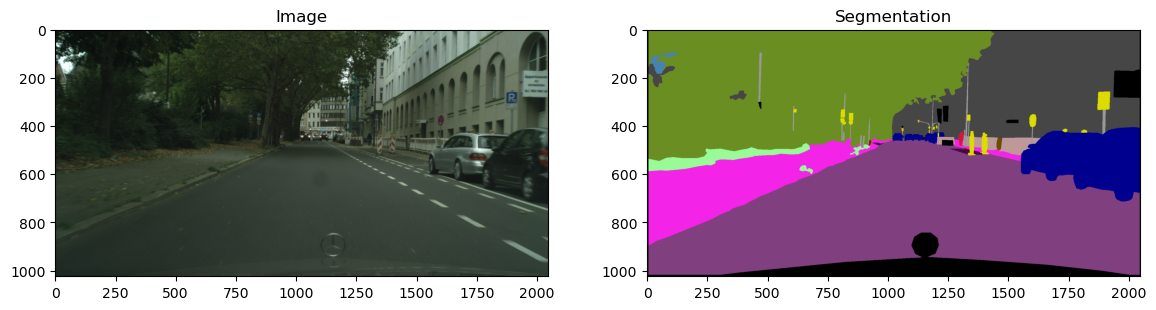

In [3]:

N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

ig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :])
arr[1].set_title('Segmentation')
plt.show()

In [4]:
image_list = sorted(image_list)  # Sort the image paths
mask_list = sorted(mask_list)    # Sort the mask paths

# Create datasets from sorted paths
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

# Check if the number of images and masks match
if len(image_list) != len(mask_list):
    raise ValueError("The number of images and masks don't match!")

# Iterate over pairs of images and masks
for image_path, mask_path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(f"Image path: {image_path.numpy()}, Mask path: {mask_path.numpy()}")

Image path: b'.\\leftImg8bit\\train\\aachen\\aachen_000000_000019_leftImg8bit.png', Mask path: b'.\\gtFine\\train\\aachen\\aachen_000000_000019_gtFine_color.png'
Image path: b'.\\leftImg8bit\\train\\aachen\\aachen_000001_000019_leftImg8bit.png', Mask path: b'.\\gtFine\\train\\aachen\\aachen_000001_000019_gtFine_color.png'
Image path: b'.\\leftImg8bit\\train\\aachen\\aachen_000002_000019_leftImg8bit.png', Mask path: b'.\\gtFine\\train\\aachen\\aachen_000002_000019_gtFine_color.png'


In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png', shape=(), dtype=string)
tf.Tensor(b'./gtFine/train/aachen/aachen_000000_000019_gtFine_color.png', shape=(), dtype=string)


In [6]:
CITYSCAPES_COLORMAP = {
    (128, 64,128): 0,   # road
    (244, 35,232): 1,   # sidewalk
    (70, 70, 70): 2,    # building
    (102,102,156): 3,   # wall
    (190,153,153): 4,   # fence
    (153,153,153): 5,   # pole
    (250,170, 30): 6,   # traffic light
    (220,220,  0): 7,   # traffic sign
    (107,142, 35): 8,   # vegetation
    (152,251,152): 9,   # terrain
    (70,130,180): 10,   # sky
    (220, 20, 60): 11,  # person
    (255,  0,  0): 12,  # rider
    (  0,  0,142): 13,  # car
    (  0,  0, 70): 14,  # truck
    (  0, 60,100): 15,  # bus
    (  0, 80,100): 16,  # train
    (  0,  0,230): 17,  # motorcycle
    (119, 11, 32): 18,  # bicycle
    (  0,  0,  0): 19,  # unlabeled
}

In [7]:
def rgb_to_class(mask):
    mask = tf.cast(mask, tf.uint8)
    mask_shape = tf.shape(mask)[:2]
    class_map = tf.zeros(mask_shape, dtype=tf.int32)

    for rgb, class_idx in CITYSCAPES_COLORMAP.items():
        matches = tf.reduce_all(tf.equal(mask, rgb), axis=-1)
        class_map = tf.where(matches, class_idx, class_map)
    
    return class_map


In [8]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)  # keep 3 channels for color
    mask = rgb_to_class(mask)  # convert to class indices
    return img, mask


def preprocess(image, mask):
    image = tf.image.resize(image, (96, 128))
    image = image / 255.0

    mask = tf.image.resize(mask[..., tf.newaxis], (96, 128), method='nearest')
    mask = tf.squeeze(mask, axis=-1)
    mask = tf.cast(mask, tf.int32)

    return image, mask

# Load dataset from image and mask paths
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [9]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(rate=dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(2,2)(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [10]:
input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]


inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 96, 128, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]]
        

In [11]:
# UNQ_C2
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    return conv

In [12]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 12, 16, 256)], 0],
            ['Conv2DTranspose', (None, 24, 32, 32), 73760],
            ['InputLayer', [(None, 24, 32, 128)], 0],
            ['Concatenate', (None, 24, 32, 160), 0],
            ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

In [13]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0],  n_filters*16, dropout_prob=0.3, max_pooling=False) 
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [14]:
import outputs
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [15]:
unet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 96, 128, 3)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 96, 128, 32)       │             896 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 96, 128, 32)       │           9,248 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 48, 64, 32)        │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 48, 64, 64)        │          18,496 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 48, 64, 64)        │          36,928 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 24, 32, 64)        │               0 │ conv2d_9[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 24, 32, 128)       │          73,856 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 24, 32, 128)       │         147,584 │ conv2d_10[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 12, 16, 128)       │               0 │ conv2d_11[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 12, 16, 256)       │         295,168 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_13 (Conv2D)            │ (None, 12, 16, 256)       │         590,080 │ conv2d_12[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 12, 16, 256)       │               0 │ conv2d_13[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 6, 8, 256)         │               0 │ dropout_1[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_14 (Conv2D)            │ (None, 6, 8, 512)         │       1,180,160 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 8,640,471 (32.96 MB)

 Trainable params: 8,640,471 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
def display(display_list, color_map=None):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])

        if i == 0:  # Input image
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:  # Mask images
            if color_map is not None:  # Apply the color map if it exists
                mask_colored = color_map[display_list[i]]  # Apply the color map to the mask
                plt.imshow(mask_colored)
            else:
                plt.imshow(display_list[i])  # Directly display the mask
        plt.axis('off')
    plt.show()

Mask shape: (1024, 2048)


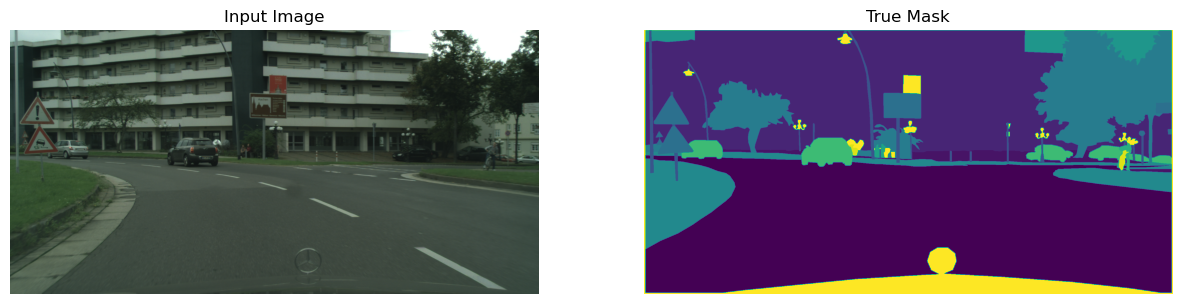

In [18]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(f"Mask shape: {sample_mask.shape}")
    display([sample_image, sample_mask])

In [52]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=400, verbose =1)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128), dtype=tf.int32, name=None))
Epoch 1/400
6/6 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.6309 - loss: 1.0878
Epoch 2/400
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6558 - loss: 0.9902
Epoch 3/400
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6612 - loss: 0.9806
Epoch 4/400
6/6 ━━━━━━━━━━━━━━━━━━━━ 5238s 1047s/step - accuracy: 0.6647 - loss: 0.9646
Epoch 5/400
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.6872 - loss: 0.9502
Epoch 6/400
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.6951 - loss: 0.9244
Epoch 7/400
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6998 - loss: 0.9105
Epoch 8/400
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7075 - loss: 0.9021
Epoch 9/400
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7076 - loss: 0.8963
Epoch 10/400
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6937 - loss: 0.9098
Epoch 11/400
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/s

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
plt.plot(model_history.history["accuracy"])
plt.show()

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


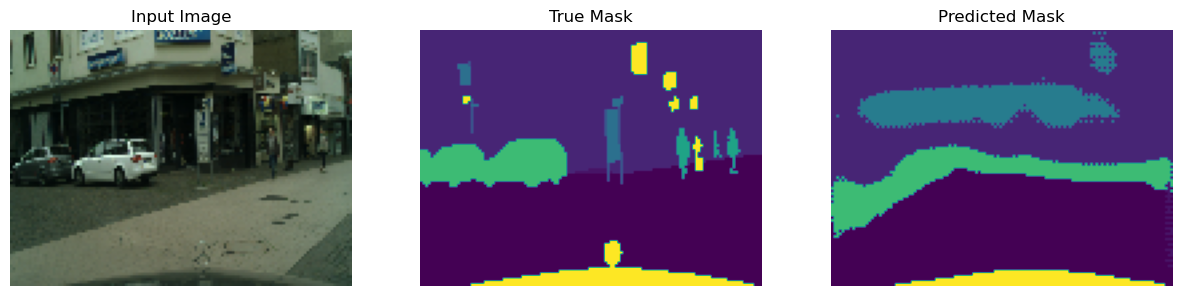

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


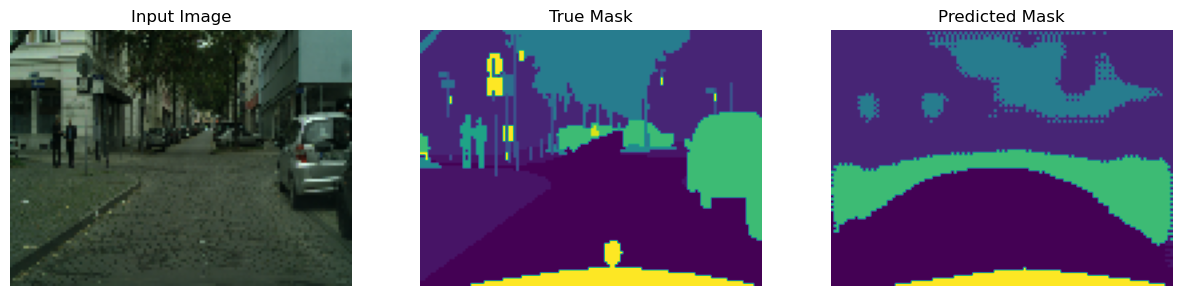

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


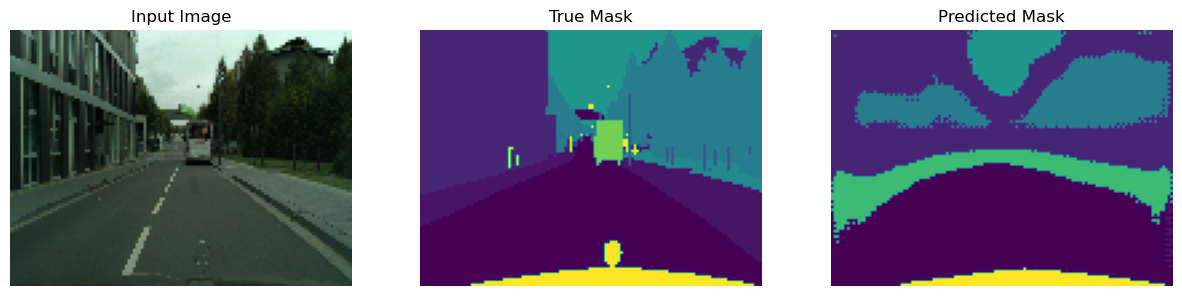

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


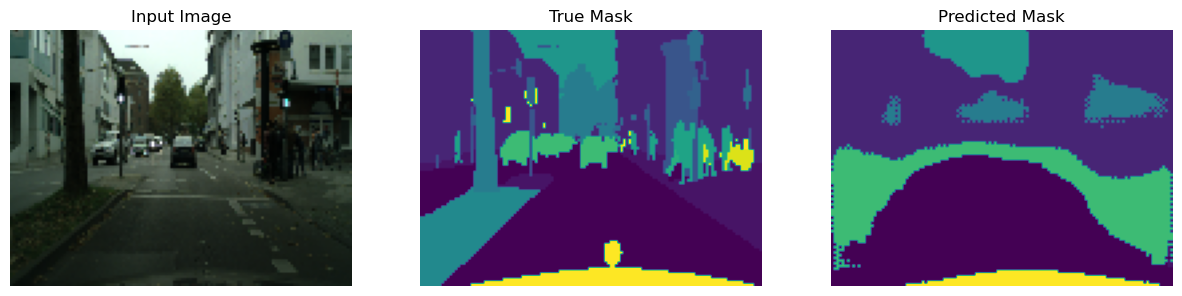

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


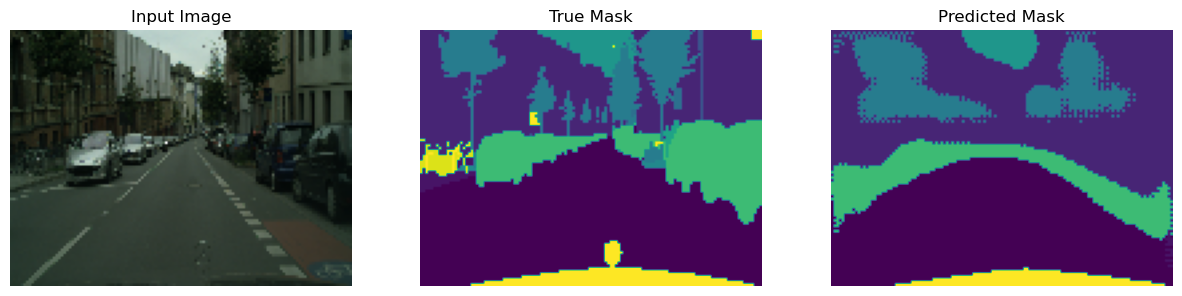

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


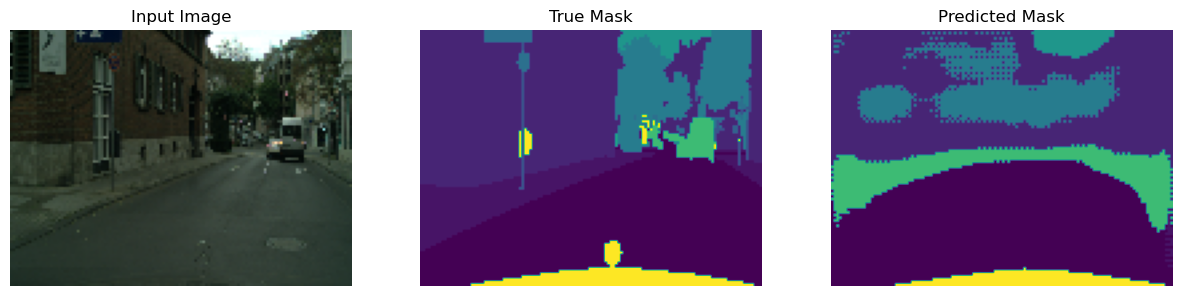

In [50]:
show_predictions(train_dataset, 6)